# Charts for bus service opportunities by tract and CalEnviroScreen / Density Scores

* Density and CalEnviroScreen both grouped as low/med/high
* Provide some charts to accompany maps
* Heatmaps to show distribution?
* Scatterplot of pop density vs service density

In [1]:
# -- DO ONCE in terminal
# !conda install --yes -c conda-forge --file conda-requirements.txt

# npm worked a bit, but now has error using altair_saver
# https://stackoverflow.com/questions/62601904/altair-saver-valueerror-unsupported-format-png
#!npm install vega-lite vega-cli canvas

In [2]:
import altair as alt
import altair_saver
import branca
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import prep_data
import map_utils
import shared_utils

alt.themes.enable("fivethirtyeight")
alt.data_transformers.enable('default', max_rows=10_000)
alt.renderers.enable('altair_saver', fmts=['vega-lite'])

pd.set_option("display.max_rows", 20)        

In [3]:
df = prep_data.generate_stop_times_tract_data()

TOTAL_CA_TRACTS = len(df)

# Address small numbers issue
df = df[df.Population > 10].reset_index(drop=True)

## Heatmap by Equity and Density Groups

In [4]:
def aggregate_generate_stats(df, group_cols, aggregate_dict):
    t1 = shared_utils.geography_utils.aggregate_by_geography(
        df, 
        group_cols = group_cols, 
        sum_cols = aggregate_dict["sum_cols"], 
        mean_cols = aggregate_dict["mean_cols"],
        count_cols = aggregate_dict["count_cols"], 
        nunique_cols = aggregate_dict["nunique_cols"]
    ).astype("int").sort_values(group_cols)
    
    DENOM = 1_000
    t1 = t1.assign(
        arrivals_per_1k_pj = (t1.num_arrivals / t1.num_pop_jobs) * DENOM,
        stops_per_1k_pj = (t1.stop_id / t1.num_pop_jobs) * DENOM,
    )  
    
    return t1

In [5]:
aggregate_dict = {
    "sum_cols": ["stop_id", "itp_id", "Population", 
                 "num_jobs", "num_pop_jobs", "num_arrivals"],
    "mean_cols": [],
    "count_cols": ["Tract"],
    "nunique_cols": [],
}


LEGEND_LABELS = {
    1: "Low",
    2: "Med",
    3: "High"
}

LEGEND_ORDER = list(LEGEND_LABELS.values())

by_density_equity = aggregate_generate_stats(df, 
                              group_cols = ["popjobdensity_group", "equity_group"],
                              aggregate_dict = aggregate_dict)

by_density_equity = by_density_equity.assign(
    popjobdensity_group = by_density_equity.popjobdensity_group.map(LEGEND_LABELS)
)

by_density_equity

,popjobdensity_group,equity_group,Population,itp_id,num_arrivals,num_jobs,num_pop_jobs,stop_id,Tract,arrivals_per_1k_pj,stops_per_1k_pj
10,Low,0,70331,38,12533,82354,152685,246,51,82.084029,1.611160
0,Low,1,6483574,1257,170205,1611989,8095563,8933,1369,21.024480,1.103444
8,Low,2,4044223,731,113556,1527032,5571255,5635,776,20.382481,1.011442
4,Low,3,2637676,434,84897,1308515,3946191,3895,461,21.513657,0.987028
11,Med,0,55740,10,11854,74090,129830,156,14,91.304013,1.201571
6,Med,1,4192427,909,182187,1324761,5517188,7196,857,33.021713,1.304288
7,Med,2,5069081,1381,298650,1762718,6831799,10520,1005,43.714694,1.539858
5,Med,3,3935454,1200,338126,1778113,5713567,10777,798,59.179493,1.886212
9,High,0,34118,23,10993,84203,118321,190,10,92.908275,1.605801
1,High,1,1995393,516,272334,1274857,3270250,4706,418,83.276202,1.439034


In [6]:
by_density = aggregate_generate_stats(df, 
                              group_cols = ["popjobdensity_group"],
                              aggregate_dict = aggregate_dict)

by_density

,popjobdensity_group,Population,itp_id,num_arrivals,num_jobs,num_pop_jobs,stop_id,Tract,arrivals_per_1k_pj,stops_per_1k_pj
0,1,13235804,2460,381191,4529890,17765694,18709,2657,21.456578,1.053097
2,2,13252702,3500,830817,4939682,18192384,28649,2674,45.668396,1.574780
1,3,12794954,4906,1836638,7433255,20228209,36540,2676,90.795878,1.806388


In [7]:
by_equity = aggregate_generate_stats(df, 
                              group_cols = ["equity_group"],
                              aggregate_dict = aggregate_dict)

by_equity

,equity_group,Population,itp_id,num_arrivals,num_jobs,num_pop_jobs,stop_id,Tract,arrivals_per_1k_pj,stops_per_1k_pj
3,0,160189,71,35380,240647,400836,592,75,88.265525,1.476913
0,1,12671394,2682,624726,4211607,16883001,20835,2644,37.003256,1.234082
1,2,13418830,3421,981503,6343752,19762582,27225,2644,49.664715,1.377603
2,3,13033047,4692,1407037,6106821,19139868,35246,2644,73.513412,1.841497


In [8]:
by_density_equity.sort_values(["equity_group", "popjobdensity_group"])[
    ["popjobdensity_group", "equity_group", "Tract", "arrivals_per_1k_pj"]]

,popjobdensity_group,equity_group,Tract,arrivals_per_1k_pj
9,High,0,10,92.908275
10,Low,0,51,82.084029
11,Med,0,14,91.304013
1,High,1,418,83.276202
0,Low,1,1369,21.024480
6,Med,1,857,33.021713
2,High,2,863,77.355097
8,Low,2,776,20.382481
7,Med,2,1005,43.714694
3,High,3,1385,103.797741


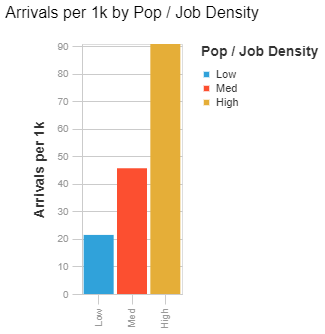

In [9]:
# Set the y-axis to be the same when comparing 
# bar charts by density or equity
DENSITY_MAX = by_density.arrivals_per_1k_pj.max()
EQUITY_MAX = by_equity.arrivals_per_1k_pj.max()
Y_MAX = max(DENSITY_MAX, EQUITY_MAX)

bar = (alt.Chart(
    by_density.assign(
        popjobdensity_group = by_density.popjobdensity_group.map(LEGEND_LABELS)
    )
 )
 .mark_bar()
 .encode(
     x=alt.X("popjobdensity_group:N", 
             axis=alt.Axis(title=""), 
             scale=alt.Scale(domain=LEGEND_ORDER)
            ),
     y=alt.Y("arrivals_per_1k_pj:Q",
             axis=alt.Axis(title="Arrivals per 1k"),
             scale=alt.Scale(domain=[0, Y_MAX])
            ),
     color=alt.Color("popjobdensity_group:N", title="Pop / Job Density", 
                    scale=alt.Scale(domain=LEGEND_ORDER, 
                                    range=shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS
                                   )
                    )
 )
)

bar = (shared_utils.altair_utils.preset_chart_config(bar)
       .properties(title="Arrivals per 1k by Pop / Job Density", 
                  width = shared_utils.altair_utils.chart_width*0.25)
)

display(bar)
bar.save("./img/arrivals_per_1k_popjobdensity.png")

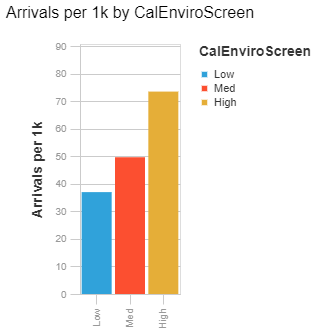

In [10]:
bar = (alt.Chart((by_equity
                  .assign(
                      equity_group = by_equity.equity_group.map(LEGEND_LABELS)
                  )))
 .mark_bar()
 .encode(
     x=alt.X("equity_group:N", 
             axis=alt.Axis(title=""), 
             scale=alt.Scale(domain=LEGEND_ORDER)
            ),
     y=alt.Y("arrivals_per_1k_pj:Q",
             axis=alt.Axis(title="Arrivals per 1k"),
             scale=alt.Scale(domain=[0, Y_MAX])
            ),
     color=alt.Color("equity_group:N", title="CalEnviroScreen", 
                    scale=alt.Scale(domain=LEGEND_ORDER, 
                                    range=shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS
                                   )
                    )
 )
)

bar = (shared_utils.altair_utils.preset_chart_config(bar)
       .properties(title="Arrivals per 1k by CalEnviroScreen", 
                  width = shared_utils.altair_utils.chart_width*0.25)
)

display(bar)
bar.save("./img/arrivals_per_1k_equity.png")

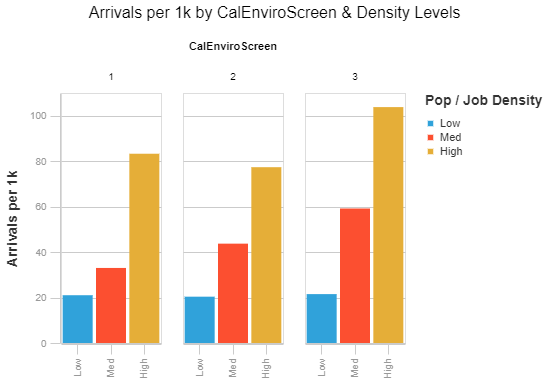

In [11]:
bar = (alt.Chart(by_density_equity[by_density_equity.equity_group > 0])
 .mark_bar()
 .encode(
     x=alt.X("popjobdensity_group:N", 
             axis=alt.Axis(title=""), 
             scale=alt.Scale(domain=LEGEND_ORDER)
            ),
     y=alt.Y("arrivals_per_1k_pj:Q",
             axis=alt.Axis(title="Arrivals per 1k")
            ),
     column=alt.Column("equity_group:N", title="CalEnviroScreen", 
                      ),
     color=alt.Color("popjobdensity_group:N", title="Pop / Job Density", 
                    scale=alt.Scale(domain=LEGEND_ORDER, 
                                    range=shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS
                                   )
                  )
 )
)


bar = (shared_utils.altair_utils.preset_chart_config(bar)
       .properties(title="Arrivals per 1k by CalEnviroScreen & Density Levels", 
                  width = shared_utils.altair_utils.chart_width*0.25)
)

display(bar)
bar.save("./img/arrivals_per_1k_bar.png")

In [12]:
def pivot_get_counts(df, index_col, group_col, value_col):
    df2 = df.pivot(index = index_col, 
                   columns = group_col, 
                   values = value_col)
    return df2

index_col = "popjobdensity_group"
group_col = "equity_group"


def make_heatmap(df, cmap, chart_title, xtitle, ytitle):
    chart = (sns.heatmap(df, cmap=cmap)
             .set(title=chart_title, xlabel=xtitle, ylabel=ytitle,
                 )
    )

    return chart

In [13]:
LOOP_DICT = {
    "Tract": "Tracts",
    "stop_id": "Bus Stops",
    "itp_id": "Operators",
    "arrivals_per_1k_pj": "Arrivals per 1k",
    "stops_per_1k_pj": "Stops per 1k",
} 

#plt.gcf().set_size_inches(1, 1)

for key, value in LOOP_DICT.items():
    subset_df = by_density_equity[by_density_equity.equity_group > 0]
    pivot_df = pivot_get_counts(subset_df, index_col, group_col, key)
    pivot_df = pivot_df.reindex(index=LEGEND_ORDER)
    
    print(key)
    display(pivot_df)
    #display(pivot_df.sort_index(axis=0, ascending=True))
    #display(pivot_df.reindex(index=LEGEND_ORDER))
    
    chart = make_heatmap(pivot_df, cmap="Blues", 
                 chart_title=(f"{value} by CalEnviroScreen" "\n and Density Levels"),
                 xtitle="CalEnviroScreen", ytitle="Pop / Job Density"   
                 )

    plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)
    plt.close()
    


Tract


equity_group,1,2,3
popjobdensity_group,,,
Low,1369,776,461
Med,857,1005,798
High,418,863,1385


/tmp/ipykernel_2489/483646027.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


stop_id


equity_group,1,2,3
popjobdensity_group,,,
Low,8933,5635,3895
Med,7196,10520,10777
High,4706,11070,20574


/tmp/ipykernel_2489/483646027.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


itp_id


equity_group,1,2,3
popjobdensity_group,,,
Low,1257,731,434
Med,909,1381,1200
High,516,1309,3058


/tmp/ipykernel_2489/483646027.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


arrivals_per_1k_pj


equity_group,1,2,3
popjobdensity_group,,,
Low,21.024480,20.382481,21.513657
Med,33.021713,43.714694,59.179493
High,83.276202,77.355097,103.797741


/tmp/ipykernel_2489/483646027.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


stops_per_1k_pj


equity_group,1,2,3
popjobdensity_group,,,
Low,1.103444,1.011442,0.987028
Med,1.304288,1.539858,1.886212
High,1.439034,1.504173,2.170228


/tmp/ipykernel_2489/483646027.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


## Scatterplot of pop density vs service density

In [14]:
y_col = "arrivals_per_1k_pj:Q"
group_col = "equity_group:N"
tooltip=['Tract', 'ZIP', 'County', 'City', 
         'pop_sq_mi', 'jobs_sq_mi', 'popjobs_sq_mi',
         'arrivals_per_1k_pj', 'equity_group']

def make_scatterplot(df, x_col, y_col, group_col, tooltip_list, chart_title):
    
    # Interactive chart should be centered near where 95th percentile data is
    # There are outliers...but let's not have it so zoomed out
    
    def colname_label(col):
        colname = col.split(":")[0]
        coltitle = colname.replace('_', ' ').replace(' pj', '').replace('popjobs', 'pop/job')
        return colname, coltitle
    
    x_colname, x_title = colname_label(x_col)
    y_colname, y_title = colname_label(y_col)
    
    MAX_X = df[x_colname].quantile(q=0.95)
    MAX_Y = df[y_colname].quantile(q=0.95)
    MEDIAN_X = df[x_colname].quantile(q=0.5)
    MEDIAN_Y = df[y_colname].quantile(q=0.5)
    
    subset_df = (df[((df[x_colname] > 0) 
                     & (df[y_colname] > 0))]
                 .assign(
                     median_x = MEDIAN_X,
                     median_y = MEDIAN_Y
                 )
                )
    
    chart = (
        alt.Chart(subset_df)
        .mark_point(size=30, fillOpacity=0.8)
        .encode(
            x=alt.X(x_col, 
                    scale=alt.Scale(domain=(0, MAX_X)), 
                    axis=alt.Axis(title=f"{x_title}")
                   ),
            y=alt.Y(y_col, 
                    scale=alt.Scale(domain=(0, MAX_Y)),
                    axis=alt.Axis(title=f"{y_title}")
                   ),
            color=group_col,
            tooltip=tooltip_list
        )
    )
    
    ptile_base = (
        alt.Chart(subset_df)
        .mark_line(clip=True)
    )
    
    
    fifty_x = (ptile_base.encode(
            x=alt.X("median_x:Q"),
            y=alt.Y(y_col),
            color=alt.value("#343537")
        )
    )
    
    fifty_y = (ptile_base.encode(
            x=alt.X(x_col),
            y=alt.Y("median_y:Q"),
            color=alt.value("#343537")
        )
    )
    
    full_chart = chart + fifty_x + fifty_y
    full_chart = (shared_utils.altair_utils.preset_chart_config(full_chart)
             .properties(title=f"{chart_title}")
             .interactive()
            )
    
   
    return full_chart

In [15]:
x_col = "popjobs_sq_mi:Q"

# Scatterplot of pop & job density vs service density
c = make_scatterplot(df[(df.equity_group > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title="Pop / Job Density vs Service Density")
c.save("./img/scatter_popjobdensity_servicedensity.html")

In [16]:
x_col = "pop_sq_mi:Q"

# Scatterplot of pop density vs service density
c = make_scatterplot(df[(df.equity_group > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title="Pop Density vs Service Density")
c.save("./img/scatter_popdensity_servicedensity.html")

In [17]:
x_col = "jobs_sq_mi:Q"
# Scatterplot of pop density vs service density
c = make_scatterplot(df[(df.equity_group > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title = "Job Density vs Service Density")
c.save("./img/scatter_jobdensity_servicedensity.html")

## Opportunity Tracts

Tracts in the lower right quandrant, but pick out the most extreme cases.

Tracts with > 75th ptile for pop/job density & < 25th ptile for service density.

Especially the medium-need tracts, these would be the ones dragging down the average for the middle yellow bar.

In [18]:
# Grab the ones with density above 75th percentile
# and in the lower 25th percentile for service density
p75 = df.popjobs_sq_mi.quantile(0.75)
p25 = df.arrivals_per_1k_pj.quantile(0.25)

df = df.assign(
    flag_me = df.apply(lambda x: (x.popjobs_sq_mi > p75) and 
                       (x.arrivals_per_1k_pj < p25), axis=1)
)

pct_oppor_tracts = round(len(df[df.flag_me==1])/TOTAL_CA_TRACTS, 3)
print(f"# opportunity tracts: {len(df[df.flag_me==1])}")
print(f"% opportunity tracts of total: {pct_oppor_tracts*100}%")

# opportunity tracts: 167
% opportunity tracts of total: 2.1%


In [19]:
popup_dict = {
    "Tract": "Census Tract",
    "ZIP": "Zip Code",
    "County": "County",
    "City": "City",
    "equity_group": "CalEnviroScreen Group (3 is high need)", 
    "Population": "Population",
    "num_jobs": "Jobs",
    "popjobs_sq_mi": "Pop & Job Density Group (3 is densest)",
}


FIG_WIDTH = 800
FIG_HEIGHT = 1_000

In [20]:
plot_col = "equity_group"
arrivals_col = "arrivals_group_pj"
# For indexing cut-off, we need 1 less than the number of groups
# It goes from [vmin, cut1], [cut1, cut2], [cut2, cut3]
# Not sure where the open parantheses are [) or (]?
colormap_cutoff, MIN_VALUE, MAX_VALUE = map_utils.grab_legend_thresholds(
    df[df.flag_me==1], plot_col, arrivals_col)
print(colormap_cutoff)

colorscale = branca.colormap.StepColormap(
                colors=[shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS[0], 
                        shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS[1],
                        shared_utils.altair_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS[2],
                       ], 
                #index=[1, 2, 3],
                vmin=1, vmax=3,
)

# May need to adjust colorscale, how it shows up on map...
fig = shared_utils.map_utils.make_folium_choropleth_map(df[df.flag_me==1], 
                                plot_col = plot_col, 
                                popup_dict = popup_dict, 
                                tooltip_dict = popup_dict, 
                                colorscale = colorscale, 
                                fig_width = FIG_WIDTH, fig_height = FIG_HEIGHT, 
                                zoom = shared_utils.map_utils.REGION_CENTROIDS["CA"][1], 
                                centroid = shared_utils.map_utils.REGION_CENTROIDS["CA"][0],
                                title=f"Opportunity Tracts by CalEnviroScreen Need",
                               )
fig.save(f"./img/opportunity_tracts.html")

[1, nan, nan]


### List these cities where opportunity tracts fall

In [21]:
display_cols = [
    "County", "City", "ZIP"
]

for county in ["Santa Clara", "Los Angeles", "Sacramento"]: 
    df2 = df[df.flag_me==1].reset_index(drop=True)
    df3 = df2.drop_duplicates(subset=["County", "City"])
    display(df3[df3.County==county][display_cols])
    print(df3[df3.County==county].City.unique())

,County,City,ZIP
69,Santa Clara,San Jose,95112
89,Santa Clara,Campbell,95008
98,Santa Clara,Unincorporated Santa Clara County area,95111
118,Santa Clara,Alum Rock,95127
124,Santa Clara,Milpitas,95035
125,Santa Clara,Sunnyvale,94089
128,Santa Clara,Santa Clara,95054
143,Santa Clara,Cupertino,95014
151,Santa Clara,Mountain View,94041
156,Santa Clara,Palo Alto,94306


['San Jose' 'Campbell' 'Unincorporated Santa Clara County area'
 'Alum Rock' 'Milpitas' 'Sunnyvale' 'Santa Clara' 'Cupertino'
 'Mountain View' 'Palo Alto']


,County,City,ZIP
5,Los Angeles,Los Angeles,91352
11,Los Angeles,Glendale,91207
12,Los Angeles,Burbank,91501
14,Los Angeles,El Monte,91732
15,Los Angeles,Rosemead,91770
16,Los Angeles,Whittier,90601
18,Los Angeles,La Mirada,90638
19,Los Angeles,Montebello,90640
23,Los Angeles,Maywood,90270
24,Los Angeles,Huntington Park,90255


['Los Angeles' 'Glendale' 'Burbank' 'El Monte' 'Rosemead' 'Whittier'
 'La Mirada' 'Montebello' 'Maywood' 'Huntington Park' 'Cudahy'
 'South Gate' 'Bellflower' 'Culver City']


,County,City,ZIP
38,Sacramento,Sacramento,95816
51,Sacramento,Arden-Arcade,95825
56,Sacramento,Foothill Farms,95842
58,Sacramento,Folsom,95630
59,Sacramento,Rancho Cordova,95670
60,Sacramento,Rosemont,95826


['Sacramento' 'Arden-Arcade' 'Foothill Farms' 'Folsom' 'Rancho Cordova'
 'Rosemont']
